# Degrees of Influence: Parental Education's Impact on University Dropout Rates
### STAT 201 Project

## Introduction

Higher education institutions are constantly striving to improve student retention and academic success. For this purpose, a comprehensive dataset has been collected from various disjoint databases related to students enrolled in different undergraduate degree programs in an effort to decrease the failure and dropout rate of students. (https://oa.mg/work/10.1007/978-3-030-72657-7_16) The institutions this data set was taken from offers a wide range of programs, encompassing a diverse range of disciplines, including agronomy, design, education, nursing, journalism, management, social service, and technologies. Higher education has the potential to allow significantly different career paths for individuals who pursue a university or college degree but not every student is well supported in these educational institutes. Addressing student dropout rates is a critical concern. This research endeavour seeks to investigate a specific aspect of this challenge, namely whether the dropout rate among students whose parents have received higher-level education exceeds that of students whose parents have not attained such educational qualifications. 

#### Background:

The research question at hand is rooted in the persistent challenge of student dropout rates within higher education institutions. It specifically delves into the potential influence of parental educational backgrounds on student retention. While higher education offers students the opportunity for personal and professional growth, not all students navigate their academic journey without obstacles.

A main motivation for this investigation is from a paper by Dr. Selpher (https://ijmsssr.org/paper/IJMSSSR00996.pdf) that examines the relationship between parents’ socio-economic status and students’ dropout rates in secondary schools in Kenya. It finds that parents’ education level, occupation, income, and assets have a significant effect on students’ dropout rates. It also reveals that students with parents who have higher education levels are more likely to drop out than those with parents who have lower education levels. Mental stress, high expectations, and freedom of choice that are reflected in families with parents that have recieved higher education. As such, these pivotal factors in student academic sucess may effect how we percieve the influence of parental education.

The influence of parental education on student outcomes has been a subject of interest for years. This research question seeks to contribute to this body of knowledge by focusing on the connection between parents' educational attainment and student dropout rates. By doing so, it aims to identify a potential factor that could impact the academic success and persistence of students.

#### Significance:

The significance of this project lies in its potential to shed light on a crucial aspect of student dropout rates within the context of parental education. If the data uncovers a statistically significant difference between the two groups, it could inform policies and interventions to better support students, particularly those with parents who have not received higher-level education. The ramifications extend beyond the academic realm, as the findings may have implications for social and economic equity. (https://unesdoc.unesco.org/ark:/48223/pf0000190771) A deeper understanding of this relationship can help institutions tailor their support systems and interventions more effectively, potentially levelling the playing field for all students, regardless of their parental educational backgrounds.

#### Dataset used: (https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

The above dataset will be used in this project, the data includes a large number of students with numerous variables that describe each student's unique personal background and their success or failure at the institution.

#### Research Question

**Is the dropout rate of students with parents that recieved higher level education greater than those whose parents have not recieved higher level education?**

- higher level education refers to education beyond the highschool level
- parents are considered to recieve higher level education as long as *one* parent have recived higher level eduction

$H_0: p_1 = p_2$  
$H_a: p_1 > p_2$  
$p_1$: proportion of student dropout with parents that recieved higher level education  
$p_2$: proportion of student dropout with parents that have **not** recieved higher level education

Hypothesis testing will be conducted with $\alpha = 1$.

#### Variables of Interest:

Mother's and Father's qualifications, Admission grade. We will also filter students based on variables such as `Educational special needs`, `Tuition fees up to date`, `Daytime/evening attendance` and `Marital Status`.


## Preliminary Analysis

This section will include:
- Retrieving  data from UCI database and importing it into R
- Wrangling and cleaning the data to get a tidy dataset
- Computing the point estimates of the parameter of interest and putting in table for observation
- Plotting relevant data
    - Classifying parents' education levels
    - Calculating relative dropout rates

In [1]:
# Constants
DATASET_URL <- "https://raw.githubusercontent.com/MehrshadEsm/stat-201-project/main/data.csv"
DATA_FIELDS <- c("Mother's qualification", "Father's qualification", "Educational special needs", "Daytime/evening attendance\t", "Tuition fees up to date", "Marital status", "Admission grade") 

In [2]:
# Load liraries and set seed
set.seed(1234)
library(tidyverse)
library(tidymodels)
library(infer)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Reading and Cleaning Data

The `Target` variable describes 3 possible outcomes for students - "Graduate," "Dropout," or staying "Enrolled." This analysis will specifically focus on the proportion of students who have dropped out.

Moreover, the variables `Mother's qualification` and `Father's qualification` describe the parents' education level, where each number corresponds to the specific education experience (details [here](#Wrangling-and-Visualizing-Data)). Note: the order of these values is arbitrary, and it does not indicate the education level!

In addition to the parental education level, it is equally important to consider other variables that might influence the student dropout rates. Variables such as `Educational special needs`, `Tuition fees up to date`, `Daytime/evening attendance` and `Marital Status` are critical factors that can directly influence the student dropout rates. To elaborate further on this topic, these variables can introduce bias to the data in different ways:

- Educational special needs: Students that require special care can cause outliers in the dataset.
- Tuition fees up to date: Reflect the financial status of the students.
- Daytime/evening attendance: Indicates the quality of education students ge; keeping it constant for fair comparison.
- Marital Status: Can cause significant variability in students' lives - single students being the majority and the other students statuses being the outliers.

To minimize the bias cause by other factors, we will filter our population based on a specific character of a subset of students. Moreover, the admission grade of the student is also the significant variable that can provide further insights into our investigation.

In [55]:
# load data from url
student_data_raw <- read_delim(DATASET_URL, delim = ";")

# select target columns
student_data <- 
    student_data_raw |>
    select(Target, all_of(DATA_FIELDS))

head(student_data)
cat("[Table 1] Unwrangled Student Data with Relevant Variables")

Rows: 4424 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Target
dbl (36): Marital status, Application mode, Application order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Target,Mother's qualification,Father's qualification,Educational special needs,Daytime/evening attendance,Tuition fees up to date,Marital status,Admission grade
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Dropout,19,12,0,1,1,1,127.3
Graduate,1,3,0,1,0,1,142.5
Dropout,37,37,0,1,0,1,124.8
Graduate,38,37,0,1,1,1,119.6
Graduate,37,38,0,0,1,2,141.5
Graduate,37,37,0,0,1,2,114.8


[Table 1] Unwrangled Student Data with Relevant Variables

## Wrangling and Visualizing Data 

For the purpose of the analysis, we need to classify parents' education level into two distinct categories - those who have received the higher education, and those who have not received the higher education. To classify this way, we use the UCI dataset description, and we classify the education levels in numerical way as follows:


- **Recieved Higher Education:**  
**2** - Bachelor's Degree, 
**3** - Degree, 
**4** - Master's, 
**5** - Doctorate, 
**22** - Technical-professional course, 
**40** - degree (1st cycle), 
**41** - Specialized higher studies course, 
**42** - Professional higher technical course, 
**43** - Master (2nd cycle), 
**44** - Doctorate (3rd cycle),
**39** - Technological specialization course.

- **Have Not Recieved Higher Education:**  
**1** - Secondary Education, 
**9** - 12th Year of Schooling - Not Completed,
**10** - 11th Year of Schooling - Not Completed, 
**11** - 7th Year, 
**12** - 11th Year of Schooling,
**14** - 10th Year of Schooling 18, 
**19** - Basic Education 3rd Cycle (9th/10th/11th Year), 
**26** - 7th year of schooling, 
**27** - 2nd cycle of the general high school course, 
**29** - 9th Year of Schooling - Not Completed, 
**30** - 8th year of schooling, 
**35** - Can't read or write, 
**36** - Can read without having a 4th year of schooling, 
**37** - Basic education 1st cycle (4th/5th year), 
**38** - Basic Education 2nd Cycle (6th/7th/8th Year). 

- **Outliers (ignored)**:  
**34** - Unknown , 
**6** - Frequency of Higher Education 


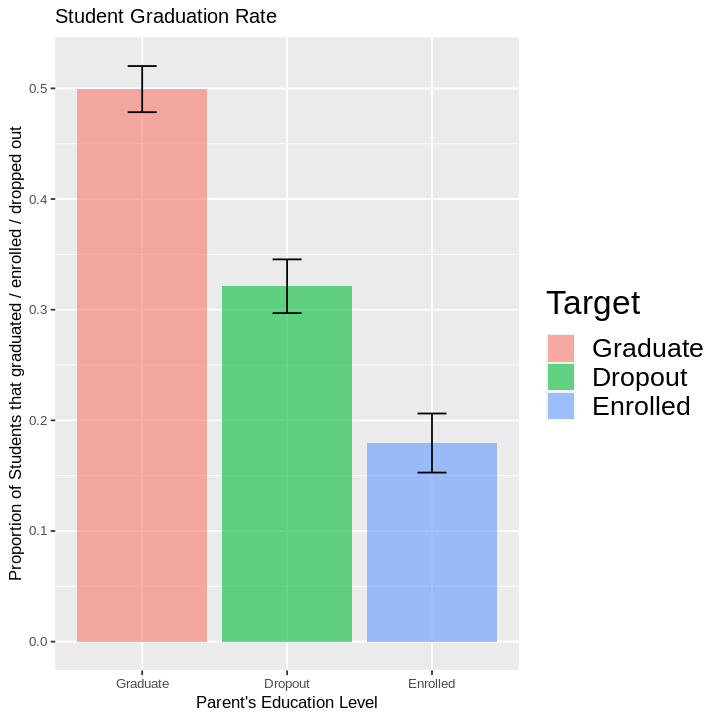

In [76]:
higher_edu = c(2, 3, 4, 5, 22, 40, 41, 42, 43, 44, 39)
not_higher_edu = c(1, 9, 10, 11, 12, 14, 19, 26, 27, 29, 30, 35, 36, 37, 38)
outliers = c(34, 6)

# removing data where parents' education level are outliers
student_data_edu_unfiltered <- 
    student_data |>
    filter(!(`Mother's qualification` %in%  outliers | `Father's qualification` %in%  outliers)) |>
    mutate(one_higher_edu  = ((`Mother's qualification` %in%  higher_edu) | (`Father's qualification` %in%  higher_edu)),
           both_higher_edu = ((`Mother's qualification` %in%  higher_edu) & (`Father's qualification` %in%  higher_edu)))

options(repr.plot.width = 6, repr.plot.height = 6)

mother_higher_edu <- 
    student_data |>
    filter(`Mother's qualification` %in% higher_edu & !(Target %in% "Enrolled"))

father_higher_edu <- 
    student_data |>
    filter(`Father's qualification` %in% higher_edu & !(Target %in% "Enrolled"))

# theme(axis.title = element_text(size = 10), axis.text = element_text(size = 8), plot.title = element_text(size = 12))

education_summary <- student_data %>% 
  group_by(Target) %>% 
  summarize(n = n(),
            prop = n() / nrow(student_data),
            se = sqrt(prop * (1 - prop) / n()),
            lower_ci = prop - qnorm(0.975) * se,
            upper_ci = prop + qnorm(0.975) * se) %>% 
  mutate(Target = fct_reorder(Target, prop, .desc = TRUE))

education_summary_plot <- 
    education_summary %>% 
    ggplot(aes(x = Target, y = prop, fill = Target)) +
      geom_bar(stat = "identity",
               alpha = .6) +
      geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci),
                    size = 0.5, color = "black", width=.2) +
      xlab("Parent's Education Level") +
      ylab("Proportion of Students that graduated / enrolled / dropped out") +
      theme(text = element_text(size = 20)) + 
      ggtitle("Student Graduation Rate")

education_summary_plot + theme(axis.title = element_text(size = 10), axis.text = element_text(size = 8), plot.title = element_text(size = 12))

## Filtering Data

To minimize the bias caused by other factors, we will filter the data further - considering only students that don't require special education assistance, have paid off all their tuition fees, have attended day school, and whose marital stats is 'single'. These categorical values are represented numerically within the dataset as follows:

- Educational special needs: 1 – yes, 0 – no
- Tuition fees up to date: 1 – yes, 0 – no
- Daytime/evening attendance: 1 – yes, 0 – no
- Marital Status: 1 – single, 2 – married, 3 – widower, 4 – divorced, 5 – facto union, 6 – legally separated

In [8]:
# filtering the data considering students that satisfy previously described criteria
student_data_edu <-
    student_data_edu_unfiltered |>
    filter(`Educational special needs` == 0 &
           `Tuition fees up to date` == 1 &
           `Daytime/evening attendance\t` == 1 &
           `Marital status` == 1) |>
    select(-`Educational special needs`, -`Daytime/evening attendance\t`, -`Marital status`, -`Tuition fees up to date`)

head(student_data_edu)
cat("[Table 2] Summary of Student Dropout Rates with Classification")

Target,Mother's qualification,Father's qualification,Admission grade,one_higher_edu,both_higher_edu
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Dropout,19,12,127.3,FALSE,FALSE
Graduate,38,37,119.6,FALSE,FALSE
Graduate,19,38,128.4,FALSE,FALSE
Graduate,1,1,129.3,FALSE,FALSE
Graduate,38,19,130.6,FALSE,FALSE
Graduate,19,38,119.3,FALSE,FALSE


[Table 2] Summary of Student Dropout Rates with Classification

## Summary of Data

Furthermore, we summarize the data by calculating the point estimates of the dropout rates. Moreover, since the education level is classified as a random binomial categorical value, and the sample size for each category is greater than 10, we will apply the Central Limit Theorem to estimate the standard deviation as follows:

$$\hat{p}\sim N\left(p, \sqrt{\frac{p(1-p)}{n}}\right)$$

In [15]:
# creating the proportion table with the standard deviation
n <- nrow(student_data_edu)

# calculating point estimates for each category: 
# proportions of dropout, sizes, standard deviations, and mean admission grades for students within that category

student_dropout_props_one <-
    student_data_edu |>
    group_by(one_higher_edu) |>
    summarize(`Proportion of Dropout` = sum(Target == "Dropout") / n(),
              Size = n(), 
              `Standard Deviation` = sqrt(`Proportion of Dropout` * (1 - `Proportion of Dropout`) / n),
              `Mean Admission Grade` = mean(`Admission grade`))

student_dropout_props_both <-
    student_data_edu |>
    group_by(both_higher_edu) |>
    summarize(`Proportion of Dropout` = sum(Target == "Dropout") / n(),
              Size = n(), 
              `Standard Deviation` = sqrt(`Proportion of Dropout` * (1 - `Proportion of Dropout`) / n),
              `Mean Admission Grade` = mean(`Admission grade`))

student_dropout_props_one
cat("[Table 3] Summary Table of Dropout Proportions for Students with at Least One Higher-Educated Parent \n\n\n\n")


student_dropout_props_both
cat("[Table 3] Summary Table of Dropout Proportions for Students with Both Higher-Educated Parents \n\n\n\n")

one_higher_edu,Proportion of Dropout,Size,Standard Deviation,Mean Admission Grade
<lgl>,<dbl>,<int>,<dbl>,<dbl>
FALSE,0.2102748,2511,0.007261817,126.8448
TRUE,0.2351097,638,0.007556985,129.7033


[Table 3] Summary Table of Dropout Proportions for Students with at Least One Higher-Educated Parent 





both_higher_edu,Proportion of Dropout,Size,Standard Deviation,Mean Admission Grade
<lgl>,<dbl>,<int>,<dbl>,<dbl>
FALSE,0.2115123,2936,0.007277445,127.0028
TRUE,0.2676056,213,0.007889215,133.2291


[Table 3] Summary Table of Dropout Proportions for Students with Both Higher-Educated Parents 





Although we have generated two tables, we will primarily focus on the case with at least one higher-educated parent. The second table is kept only for the comparison and future analysis purposes. 

The summarized data shows promising initial results - it seems to follow our alternative hypothesis stated in the introduction. However, the difference in proportions is relatively small, and therefore, we would need to perform more tests to confirm the accuracy and validity of our sample point estimates. Moreover, the variances of the two samples are relatively similar, enabling us to perform two-sample T-tests on our data to test our hypotheses. It is also very interesting fact to mention that in this dataset, the majority of the current students do not have parents that recieved higher education.

At first glance, our summarized point estimates suggest that the students with parents who have received higher education are more likely to drop out. In addition, the mean admission grade also indicates that students with higher admission grades have a higher dropout rate! Tentatively, this may imply that academic performance is not the sole factor contributing to the student dropout, and other factors may be the root cause. Some potential causes could include the following:

- These students may face more pressure from their parents to excel academically and pursue prestigious careers, which can lead to stress, anxiety, and burnout.
- They may have more opportunities and resources to explore alternative paths of education or employment, such as online courses, entrepreneurship, or travel.
- They may have higher expectations of themselves and their schools, and feel dissatisfied or bored with the quality or relevance of their education.

https://unesdoc.unesco.org/ark:/48223/pf0000190771 <- add to references later

https://link.springer.com/chapter/10.1007/978-3-031-07853-8_16 <- add to references later

## Visualize Data

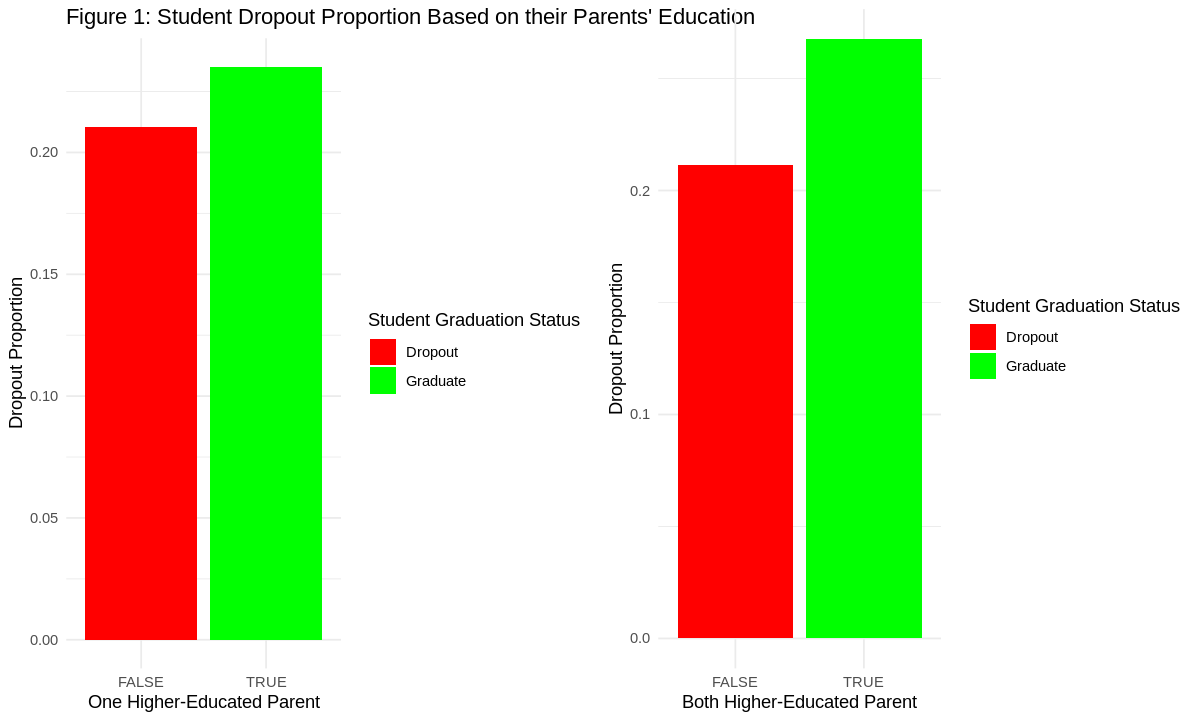

In [46]:
library(gridExtra) # for side-by-side plot

options(repr.plot.width = 10, repr.plot.height = 6)

plot_one_higher_ed_parent <- ggplot(data = student_dropout_props_one, aes(x = factor(one_higher_edu), y = `Proportion of Dropout`, fill = factor(one_higher_edu))) +
  geom_bar(stat = "identity") +
  labs(title = "Figure 1: Student Dropout Proportion Based on their Parents' Education",
       x = "One Higher-Educated Parent",
       y = "Dropout Proportion") +
  # scale_fill_discrete(name = "Students with at Least One Higher-Educated Parent") +
  scale_fill_manual(values = c("TRUE" = "green", "FALSE" = "red"), name = "Student Graduation Status", labels = c("Dropout", "Graduate")) +
  theme_minimal()

# plot_one_higher_ed_parent 


plot_both_higher_ed_parent <- ggplot(data = student_dropout_props_both, aes(x = factor(both_higher_edu), y = `Proportion of Dropout`, fill = factor(both_higher_edu))) +
  geom_bar(stat = "identity") +
  labs(# title = "Figure 2: Student Dropout Proportion Based on their Parents' Education",
       x = "Both Higher-Educated Parent",
       y = "Dropout Proportion") +
  # scale_fill_discrete(name = "Students with Both Higher-Educated Parents") +
  scale_fill_manual(values = c("TRUE" = "green", "FALSE" = "red"), name = "Student Graduation Status", labels = c("Dropout", "Graduate")) +
  theme_minimal()

# plot_both_higher_ed_parent

arranged_plots <- grid.arrange(plot_one_higher_ed_parent, plot_both_higher_ed_parent, ncol = 2)

## Methods and Results

One of the strengths of this report is that it uses a comprehensive dataset that covers various aspects of student characteristics, academic performance, and program of study. The dataset also has a large sample size with no missing values, and it has params that are suitable for two-sample z-tests, which increases the validity and reliability of the analysis. Moreover, the premise of this report is supported by various papers within the field of education, and it is likely to expect the trends to generalize for our specific population. Similarly, the source of data is supported by SATDAP, a government grant from Portugal, and it is publically available on the UCI machine learning repository, reinforcing its validity. 

From our preliminary analysis, we have discovered that students with more educated parents have a higher dropout rate. However, the plots and estimates that we produced are not sufficient to provide a conclusive answer, as they do not account for the uncertainty and variability inherent in the data. Therefore, there is a risk of arrive at inaccurate conclusions due to the inherent randomness of sampling. To address this gap, we should provide measures of confidence and significance for our estimates, such as confidence intervals and p-values. These measures will help us quantify the margin of error and the probability of obtaining the observed results by chance, respectively.

### Analysis Plan

To conduct our analysis, we will use bootstrapping to estimate sampling distribution for our proportion of dropout rates for our two populations. We will then plot the bootstrap distribution to examine its shape and variability. Using the bootstrap distribution, we will estimate the confidence interval. We will also calculate the p-value for our hypothesis test by comparing the observed difference of proportions with the bootstrap distributions. With these measures, we will be able to assess the significance and the uncertainty of our results and draw a valid conclusion about the effect of parental education on student dropout rates.

Asymptotics is another method that we will use to compare the proportions of two different populations. We will use the two-sample z-test for proportions, we can use the principle of CLT to calculate the test statistic, the p-value, and the confidence interval, as described in the previous paragraph. The advantage of asymptotics is that it is more efficient and can provide more accurate results for large and symmetric data. However, the disadvantage of asymptotics is that it can be misleading or invalid if the assumptions are violated or the sample size is too small. Therefore, we will check the assumptions before applying the asymptotic method and compare the results with the bootstrap method to see if they are consistent and reasonable.

### What do we expect to find?

Through statistical inference, we expect prove that students with more educated parents have a higher dropout rate than students with less educated parents. In other words, we expect to see a paradoxical disparity that indicates student success is not determined by academic success factors alone, but rather by a combination social, and parental influences. Ideally, the results of the study are expected to be statistically significant and reliable, with a low margin of error and a high confidence level.
 
### What impact could such findings have?

This study could shed light on the role of family in supporting student retention and academic success. It could suggest that parents’ educational experiences and expectations have an impact on their children’s educational choices and outcomes. This could have implications for the development of interventions and services that involve parents and families in the educational process, and help foster positive parent-student relationships. This will enable educational institutions to develop more just and fair policies to ensure success of all groups.

### What future questions could this lead to?

This investigation and lead to societal questions, such as the role of how other gaps in social level affect education and how can higher education institutions enhance the involvement and empowerment of parents and families in supporting student retention and academic success?

Moreover, this study can also lead to questions about family education: How does parental education affect student motivation, engagement, and satisfaction in higher education?

## References

- https://oa.mg/work/10.1007/978-3-030-72657-7_16

- https://unesdoc.unesco.org/ark:/48223/pf0000190771 

- https://link.springer.com/chapter/10.1007/978-3-031-07853-8_16

- https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

- https://ijmsssr.org/paper/IJMSSSR00996.pdf 